**Tutorial 4 - Linear Regession on Galaxy Spectra with Templates**

In this tutorial we will learn how to read data from a fits file, fit a spectrum to a series of templates and determine the spectrographic redshift of a galaxy.

When assigning redshifts to galaxies with a full observed spectrum, one typically fits model spectra for the rest-frame galaxy spectrum to the observed one while accounting for the redshift of the wavelengths. In this challenge, we first want to try to fit a local spectrum with templates using a linear regression and least-squares before trying to estimate the redshift of a redshifted spectrum.

1) Extract templates spectra from the fits file k_nmf_derived.newdefault.fits.  Use astropy.io.fits.open() for this.  The function returns a hdul object.  You can look at the contents with hdul.info().  The templates we want are in the second table - templates[1].data.  There are 5 templates with each on having 27330 wavelengths so this will be a 27330 x 5 array.  The wavelengths that correspond to pixel are in the templates[11].data.  The other tables contain templates with and without smoothing, dust, lines, etc.  You can look at them if you wish. Print the header information for the for the second table.

In [2]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
templates = fits.open('k_nmf_derived.newdefault.fits')
templates.info()
print('----------')
print(templates[1].header)
M = templates[1].data
lam = templates[11].data
print("----------")
print(np.shape(M)) 

Filename: k_nmf_derived.newdefault.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      18   (485, 5)   float32   
  1                1 ImageHDU         7   (27330, 5)   float32   
  2                1 ImageHDU         7   (27330, 5)   float32   
  3                1 ImageHDU         7   (27330, 5)   float32   
  4                1 ImageHDU         7   (27330, 5)   float32   
  5                1 ImageHDU         7   (27330, 5)   float32   
  6                1 ImageHDU         7   (27330, 5)   float32   
  7                1 ImageHDU         7   (27330, 5)   float32   
  8                1 ImageHDU         7   (27330, 5)   float32   
  9                1 ImageHDU         7   (27330, 5)   float32   
 10                1 ImageHDU         7   (10000, 5)   float32   
 11                1 ImageHDU         6   (27330,)   float32   
 12                1 ImageHDU         7   (25, 5)   float32   
 13                1 ImageHDU         7   (25, 

2) Plot the template spectra with proper axis labels.  Using log scaling makes it clearer.

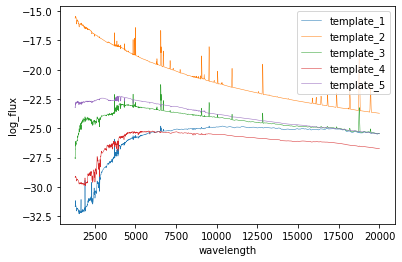

In [4]:
M_log=np.log(M)
for i in range(5):
    plt.plot(lam, M_log[i], linewidth=0.5, label='template_%s'%(i+1))
plt.xlabel(r'wavelength')
plt.ylabel('log_flux')
plt.legend()
plt.show()

Fitting templates to a spectrum:

The linear model for the spectrum is of the form
\begin{equation}
f_\lambda = \sum_i T_\lambda^i \theta^i
\end{equation}
where the $i$th template is $T_\lambda$.  This can be written in matrix notation as
\begin{equation}
\pmb{f} = \pmb{M}\pmb{\theta}
\end{equation}


In the next steps we will formulate and solve the least squares problem of finding the best fit amplitudes of the templates from part 1 when fitting them to the data of a local (i.e. redshift zero) spectrum in `localspectrum2.csv`. Implement your own linear least squares solver and compare it to `numpy`'s implementation.

3) Load a spectrum from file localspectrum2.csv (np.loadtxt()) and plot it.  This file contains both the wavelengths and the fluxes of each pixel.  (use pandas.read_csv).

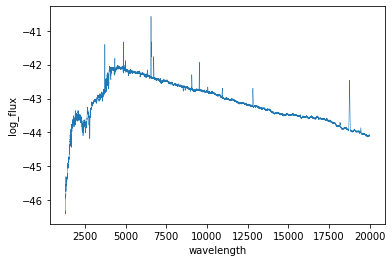

In [5]:
dat=pd.read_csv('./localspectrum2.csv')
_2=plt.plot(dat.wavelength, np.log(dat.flux), linewidth=0.5)
plt.xlabel('wavelength')
plt.ylabel('log_flux')
plt.show()

**Find the least-squares solution for the template coefficients.**

4) Make a function that returns the pseudo-inverse of the $\pmb{M}$ matrix given in the lecture notes,
\begin{equation}
\pmb{M}^+ = \left( \pmb{M}^{T} \pmb{M} \right)^{-1} \pmb{M}^T
\end{equation}
(you will need functions np.dot(), np.linalg.inv() and remember that the transpose of a matrix M is M.T.  You should be inverting a small matrix.  If you are inverting a large matrix you have not taken the transposes properly.)

Use this pseudo-inverse to find the least-squared solution and print it.  Which template galaxy is this closest to?

In [6]:
def poseudo_inverse(M=np.array([]),f=np.array([])):
    m1=np.dot(M, M.T)
    m2=np.linalg.inv(m1)
    m_pose=np.dot(m2, M)
    l_sol=np.dot(m_pose, f)
    return (l_sol)

#linear-squared solution
flux=dat.flux
ls=poseudo_inverse(M, flux)
print(ls)

[ 3.90982029e-12 -1.41598786e-15  3.89812309e-09  1.43755067e-08
  2.31916096e-12]


(27330,)


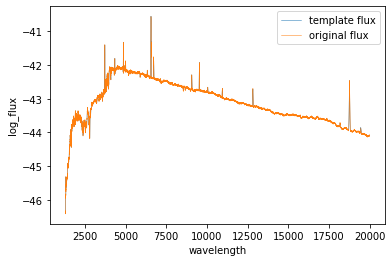

In [7]:
M_s=np.dot(M.T, ls)
print(np.shape(M_s))

plt.plot(dat.wavelength, np.log(M_s), linewidth=0.5, label='template flux')
plt.plot(dat.wavelength, np.log(dat.flux), linewidth=0.5, label='original flux')
plt.xlabel('wavelength')
plt.ylabel('log_flux')
plt.legend()
plt.show()

5) The least-squared problem can also be solved using the function  numpy.linalg.lstsq().  Use this function to solve the problem and show that it agrees with your solution above.  

[ 3.86184420e-12 -1.41747230e-15  3.89811755e-09  1.43755856e-08
  2.32007706e-12]
(27330,)


<ipython-input-8-b03cdbdd0ecf>:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ls_np=np.linalg.lstsq(M.T,flux)


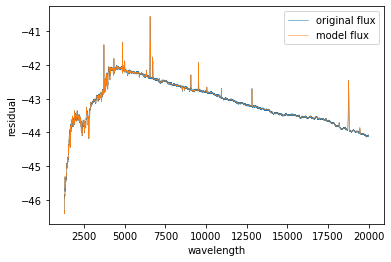

In [8]:
ls_np=np.linalg.lstsq(M.T,flux)
print(ls_np[0])

M_s=np.dot(M.T, ls)
print(np.shape(M_s))

plt.plot(dat.wavelength, np.log(dat.flux),linewidth=0.5, label='original flux')
plt.plot(dat.wavelength, np.log(M_s), linewidth=0.5, label='model flux')

plt.xlabel('wavelength')
plt.ylabel('residual')
plt.legend()
plt.show()

6) Plot the data again and the model spectrum on top of it.  The model spectrum is the some of the templates with the best fit coefficients.

7) Plot the fractional residuals as a function of $\lambda$, 

$ \frac{|~f_\lambda-d_\lambda ~|}{f_\lambda}$

where $d_\lambda$ is the data.

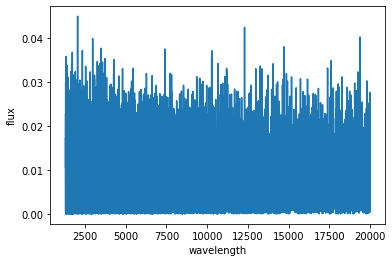

In [9]:
res=np.absolute((flux-M_s)/flux)
    
plt.plot(dat.wavelength, res)

plt.xlabel('wavelength')
plt.ylabel('flux')
plt.show()

**Fitting for the redshift**

8) Upload the data `redshiftedspectrum.txt` with np.loadtxt().  It contains a redshifted spectrum.  Use the same wavelengths as before for each pixel.

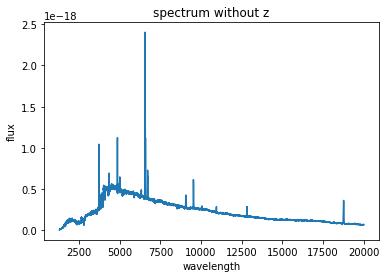

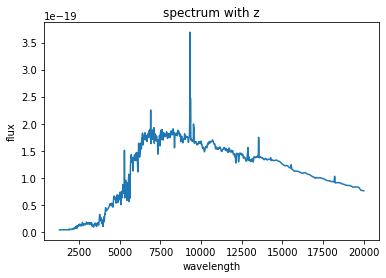

In [10]:
red_flux=np.loadtxt('/home/richard/statistics_for_astrophysics/redshiftedspectrum.txt')
#plt.plot(dat.wavelength,red)
plt.plot(dat.wavelength,dat.flux)
plt.xlabel('wavelength')
plt.ylabel('flux')
plt.title('spectrum without z')
plt.show()
plt.plot(dat.wavelength, red_flux)
plt.xlabel('wavelength')
plt.ylabel('flux')
plt.title('spectrum with z')
plt.show()

9) Fitting both redshift and template amplitudes is no longer a linear problem. The observed wavelength $\lambda_o$ is related to the restframe wavelength $\lambda$ (the wavelength it was emitted at) by
\begin{equation}
\lambda = \frac{\lambda_o }{ (1+z)}
\end{equation}

Implement the following steps:

Make an array of 1000 redshifts evenly spaced between 0 to 1.

Loop through the redshifts doing the following:

    find restframe wavelengths of the observed wavelengths

    find which wavelengths fall within the range of the template
    index = np.where(lambda < lambda_rest[-1])
 
    use the numpy.interp() function to interpolate 
       the observed spectrum to the resframe wavelengths of 
       the templates.
        yinterp = np.interp(lambda[inds], lambda_rest, data)
    
    use np.linalg.lstsq() to find the coefficients
       (make sure you only use observed wavelengths)
   
    save the residual for each redshift

In [11]:
red_t=np.arange(0,1, 0.001)
red_flux=np.array(red_flux)
fl=np.array(dat.flux)
lambd=np.array(dat.wavelength)

#yinterp=np.zeros(shape=(len(red_t),len(dat.wavelength)))
resi=np.zeros(shape=(len(red_t)))

M_t = np.transpose(M)

for z in range(len(red_t)):
    lam_gorest = lambd/(1+red_t[z])
    ind=np.where((lam_gorest < lam[-1]))
    yinterp=np.interp(lam[ind], lam_gorest, red_flux)
    ls=np.linalg.lstsq(M_t[ind], yinterp[ind], rcond=None)[0]
    FL_mod=np.dot(M_t[ind], ls)
    resi[z]=np.sum(np.abs(FL_mod-yinterp))
    #yinterp=np.reshape(yinterp,newshape=(len(yinterp),1))
    #flux_ind=np.reshape(yinterp,newshape=(len(flux_ind),1))
    #flux_ind=np.reshape(flux,newshape=(len(flux),1))    
    
print(np.shape(ls))
print(max(ls))
print(np.where(ls==max(ls)))

(5,)
2.642543687930753e-09
(array([0]),)


10) Plot the residuals as a function of redshift.
What is the best redshift? (np.argmin())

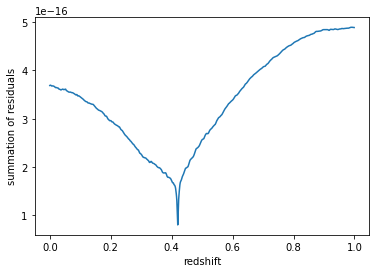

0.42
7.96154901210863e-17


In [69]:
plt.plot(red_t, resi)
plt.xlabel('redshift')
plt.ylabel('summation of residuals')
plt.show()

mini=red_t[np.argmin(resi)]
print(mini)
print(resi[np.argmin(resi)])

11) Convert what was in the loop above into a function that takes the redshift and returns the sum of squares.  Use this function scipy.optimize.minimize and an initial guess based on the results of 9) to find the best fit redshift.

In [58]:
from scipy import optimize

class redshift_estimation():
    def __init__(self, la=np.array([]),fu=np.array([])):
        self.la=la
        self.fu=fu
    
    def tem_estimation(self, z, la_tem=np.array([]), fu_tem=np.array([])):
        fu_tem_t=np.transpose(fu_tem)
        la_gorest = self.la/(1+z)
        ind=np.where((lam_gorest < la_tem[-1]))
        yinterp=np.interp(la_tem[ind], la_gorest, self.fu)
        ls=np.linalg.lstsq(fu_tem_t[ind], yinterp[ind], rcond=None)[0]
        FL_mod=np.dot(fu_tem_t[ind], ls)
        resi_sum=np.sum(np.absolute(FL_mod-yinterp))
        #ls=np.linalg.lstsq(yinterp.T, red_flux)[0]
        #best_z=np.where(ls==max(ls))
        self.FL_mod=FL_mod
        return(resi_sum)

red=redshift_estimation(lambd ,red_flux)
best=optimize.fmin(red.tem_estimation, 0.41, args=(lam, M))
print(best[0])

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 9
         Function evaluations: 18
0.42000976562500003


12) Plot the model spectrum and data with respect to observed wavelength.

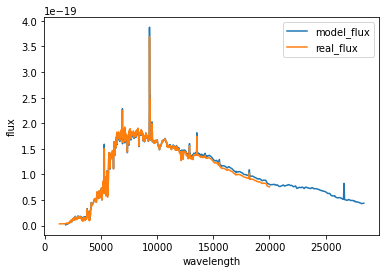

In [68]:
plt.plot(lambd*(1+best[0]), red.FL_mod, label='model_flux')
plt.plot(lambd, red_flux, label='real_flux')
plt.xlabel('wavelength')
plt.ylabel('flux')
plt.legend()
plt.show()